In [1]:
from qiskit.circuit.library import QAOAAnsatz

import parity_network
import importlib
import numpy as np

This problem is a 10-sat with 10 qubits
<br>

(¬x0​∨x1​∨x2​∨x3​∨¬x4​∨x5​∨x6​∨¬x7​∨x8​∨¬x9​)∧(x0​∨¬x1​∨¬x2​∨¬x3​∨¬x4​∨¬x5​∨x6​∨x7​∨¬x8​∨x9​)∧(¬x0​∨¬x1​∨x2​∨x3​∨x4​∨¬x5​∨x6​∨¬x7​∨x8​∨¬x9​)∧(x0​∨x1​∨¬x2​∨x3​∨x4​∨x5​∨¬x6​∨¬x7​∨¬x8​∨x9​)

In [2]:
num_qubits = 10

In [3]:
from qiskit import QuantumCircuit


def cnot_count(circuit: QuantumCircuit) -> int:
    return circuit.count_ops().get("cx", 0)

In [4]:
importlib.reload(parity_network)

parity, term_dict = parity_network.main(num_qubits)

parity_ansatz = QAOAAnsatz(parity, reps=7)
parity_ansatz.measure_all()

# parity_ansatz.decompose().draw("mpl")

Parities and Weights of the Hamiltonian:
{'0000000000': 0.0039, '0001000000': 0.002, '0000001000': 0.002, '0000000100': -0.002, '1010000000': -0.0039, '1001000000': -0.002, '1000001000': -0.002, '1000000100': 0.002, '1000000010': -0.0039, '1000000001': 0.0039, '0101000000': 0.002, '0100010000': 0.0039, '0100001000': -0.002, '0100000100': -0.002, '0011000000': 0.002, '0010001000': 0.002, '0010000100': -0.002, '0010000010': 0.0039, '0010000001': -0.0039, '0001100000': 0.002, '0001010000': 0.002, '0001000100': -0.0039, '0001000010': 0.002, '0001000001': -0.002, '0000101000': -0.002, '0000100100': -0.002, '0000011000': -0.002, '0000010100': -0.002, '0000001010': 0.002, '0000001001': -0.002, '0000000110': -0.002, '0000000101': 0.002, '0000000011': -0.0039, '1101000000': 0.002, '1100100000': 0.0039, '1100001000': -0.002, '1100000100': -0.002, '1011000000': -0.002, '1010001000': -0.002, '1010000100': 0.002, '1001100000': 0.002, '1001010000': 0.002, '1001001000': -0.0039, '1001000010': -0.002,

In [5]:
from qiskit.quantum_info import SparsePauliOp


def get_hamiltonian_observable(term_dict, n_qubits):
    # Converts a dictionary of bitstrings and weights into a Qiskit SparsePauliOp observable.
    pauli_list = []
    coeff_list = []
    for bitstring, weight in term_dict.items():
        pauli_str = ["I"] * n_qubits
        for i, bit in enumerate(bitstring):
            if bit == "1":
                pauli_str[n_qubits - 1 - i] = "Z"
        pauli_list.append("".join(pauli_str))
        coeff_list.append(weight)

    return SparsePauliOp(pauli_list, coeffs=coeff_list)

In [6]:
from scipy.optimize import minimize
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit.compiler import transpile

backend = AerSimulator()
estimator = AerEstimator()
estimator.options.shots = 10000

parity_ansatz_isa = transpile(parity_ansatz, backend=backend)

obs = get_hamiltonian_observable(term_dict, num_qubits)
print(obs)
print("CNOT count :", cnot_count(parity_ansatz_isa))

SparsePauliOp(['IIIIIIIIII', 'IIIIIIZIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IIIIIIIZIZ', 'IIIIIIZIIZ', 'IIIZIIIIIZ', 'IIZIIIIIIZ', 'IZIIIIIIIZ', 'ZIIIIIIIIZ', 'IIIIIIZIZI', 'IIIIZIIIZI', 'IIIZIIIIZI', 'IIZIIIIIZI', 'IIIIIIZZII', 'IIIZIIIZII', 'IIZIIIIZII', 'IZIIIIIZII', 'ZIIIIIIZII', 'IIIIIZZIII', 'IIIIZIZIII', 'IIZIIIZIII', 'IZIIIIZIII', 'ZIIIIIZIII', 'IIIZIZIIII', 'IIZIIZIIII', 'IIIZZIIIII', 'IIZIZIIIII', 'IZIZIIIIII', 'ZIIZIIIIII', 'IZZIIIIIII', 'ZIZIIIIIII', 'ZZIIIIIIII', 'IIIIIIZIZZ', 'IIIIIZIIZZ', 'IIIZIIIIZZ', 'IIZIIIIIZZ', 'IIIIIIZZIZ', 'IIIZIIIZIZ', 'IIZIIIIZIZ', 'IIIIIZZIIZ', 'IIIIZIZIIZ', 'IIIZIIZIIZ', 'IZIIIIZIIZ', 'ZIIIIIZIIZ', 'IIIIZZIIIZ', 'IIIZIZIIIZ', 'IIZIIZIIIZ', 'IIIZZIIIIZ', 'IIZIZIIIIZ', 'IIZZIIIIIZ', 'IZIZIIIIIZ', 'ZIIZIIIIIZ', 'IZZIIIIIIZ', 'ZIZIIIIIIZ', 'IIIIIIZZZI', 'IIIIIZIZZI', 'IIIZIIIZZI', 'IIZIIIIZZI', 'IIIIIZZIZI', 'IIIIZIZIZI', 'IZIIIIZIZI', 'ZIIIIIZIZI', 'IIIZIZIIZI', 'IIZIIZIIZI', 'IZIIIZIIZI', 'ZIIIIZIIZI', 'IIIZZIIIZI', 'IIZIZIIIZI', 'IZIZIIIIZI', 'ZIIZ

In [7]:
parity_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}


def initialize_cost_history_dict(cost_history_dict):
    cost_history_dict["iters"] = 0
    cost_history_dict["cost_history"] = []

In [8]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator, cost_history_dict):

    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    cost_history_dict["iters"] += 1
    cost_history_dict["cost_history"].append(cost)
    print(f"Iters {cost_history_dict['iters']}: Current cost: {cost}")

    return cost

In [9]:
%%time
params_init = np.random.rand(parity_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(parity_cost_history_dict)

result_parity = minimize(
    cost_func_estimator,
    params_init,
    args=(parity_ansatz_isa, obs, estimator, parity_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 0.012749999999999975
Iters 2: Current cost: 0.02563749999999996
Iters 3: Current cost: 0.0019124999999999988
Iters 4: Current cost: 0.02366249999999998
Iters 5: Current cost: 0.02961249999999998
Iters 6: Current cost: 0.0018999999999999937
Iters 7: Current cost: 0.01776249999999994
Iters 8: Current cost: 0.022699999999999988
Iters 9: Current cost: 0.0009375000000000033
Iters 10: Current cost: 0.0009749999999999956
Iters 11: Current cost: 0.003874999999999998
Iters 12: Current cost: 0.0038874999999999943
Iters 13: Current cost: -4.9999999999996445e-05
Iters 14: Current cost: 0.0019374999999999937
Iters 15: Current cost: -5.000000000000691e-05
Iters 16: Current cost: 0.016737499999999995
Iters 17: Current cost: 0.024587499999999988
Iters 18: Current cost: 0.001975
Iters 19: Current cost: 0.013787499999999986
Iters 20: Current cost: 0.03450000000000002
Iters 21: Current cost: 0.005762500000000003
Iters 22: Current cost: 0.016724999999999973
Iters 23: Current cost: 0

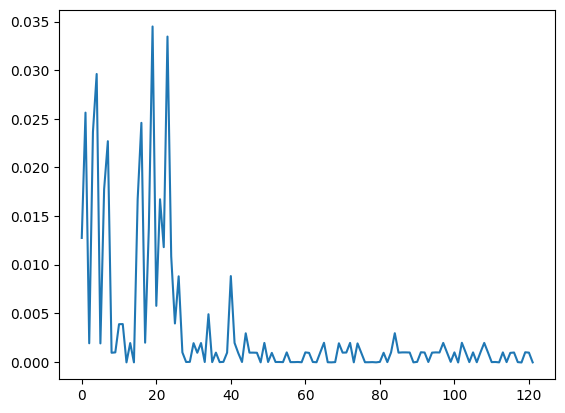

In [10]:
import matplotlib.pyplot as plt

plt.plot(parity_cost_history_dict["cost_history"])

In [11]:
naive_ansatz = QAOAAnsatz(obs, reps=7)
naive_ansatz.measure_all()

# naive_ansatz.decompose().draw("mpl")

In [12]:
naive_ansatz_isa = transpile(naive_ansatz, backend=backend)

print("CNOT count :", cnot_count(naive_ansatz_isa))

CNOT count : 32956


In [13]:
naive_cost_history_dict = {
    "iters": 0,
    "cost_history": [],

}

In [14]:
%%time
params_init = np.random.rand(naive_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(naive_cost_history_dict)

result_naive = minimize(
    cost_func_estimator,
    params_init,
    args=(naive_ansatz_isa, obs, estimator, naive_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 0.0009624999999999971
Iters 2: Current cost: 0.0029125000000000006
Iters 3: Current cost: 0.0019499999999999969
Iters 4: Current cost: 0.002924999999999999
Iters 5: Current cost: 0.0029374999999999983
Iters 6: Current cost: 0.000937499999999999
Iters 7: Current cost: 0.0009499999999999982
Iters 8: Current cost: 0.004887499999999995
Iters 9: Current cost: 0.001949999999999995
Iters 10: Current cost: -7.500000000000562e-05
Iters 11: Current cost: 0.0009375
Iters 12: Current cost: 0.000937500000000005
Iters 13: Current cost: -6.25000000000031e-05
Iters 14: Current cost: -6.250000000000068e-05
Iters 15: Current cost: -8.750000000000482e-05
Iters 16: Current cost: 0.003862500000000006
Iters 17: Current cost: 0.007824999999999981
Iters 18: Current cost: 0.000987499999999997
Iters 19: Current cost: 0.007887499999999988
Iters 20: Current cost: -5.000000000000153e-05
Iters 21: Current cost: -6.250000000000168e-05
Iters 22: Current cost: 0.0009249999999999954
Iters 23: Cur

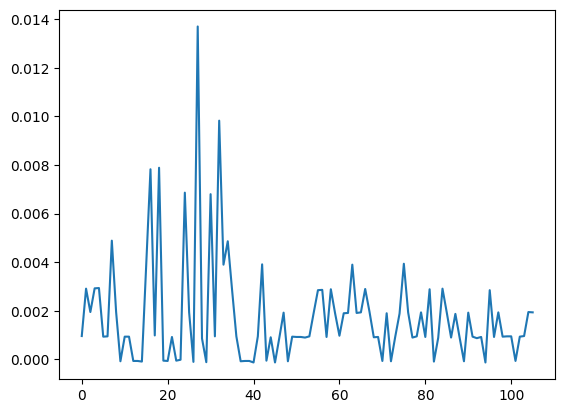

In [15]:
plt.plot(naive_cost_history_dict["cost_history"])

### Sampler

In [16]:
optimized_parity_ansatz = parity_ansatz_isa.assign_parameters(result_parity.x)

In [17]:
from qiskit_aer.primitives import SamplerV2 as AerSampler

sampler = AerSampler()
sampler.options.shots = 10000

parity_job = sampler.run([optimized_parity_ansatz])
parity_res = parity_job.result()

Parity approximation: 1011000011


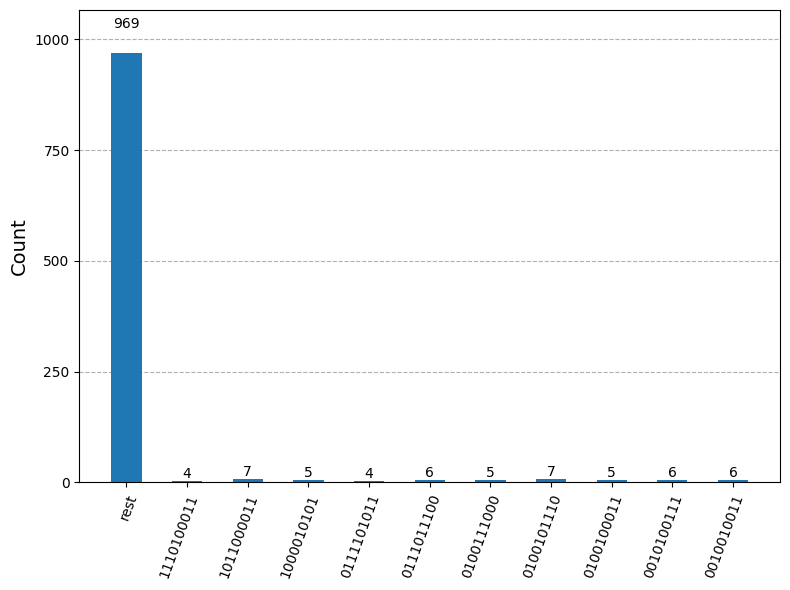

In [18]:
from qiskit.visualization import plot_histogram

counts = parity_res[0].data.meas.get_counts()
most_likely_bitstring = max(counts, key=counts.get)
parity_sol = most_likely_bitstring

print(f"Parity approximation: {parity_sol}")
plot_histogram(counts)
plot_histogram(counts, number_to_keep=10, sort='desc', figsize=(8,6))

In [19]:
optimized_naive_ansatz = parity_ansatz_isa.assign_parameters(result_naive.x)


Naive aproximation: 0101011100


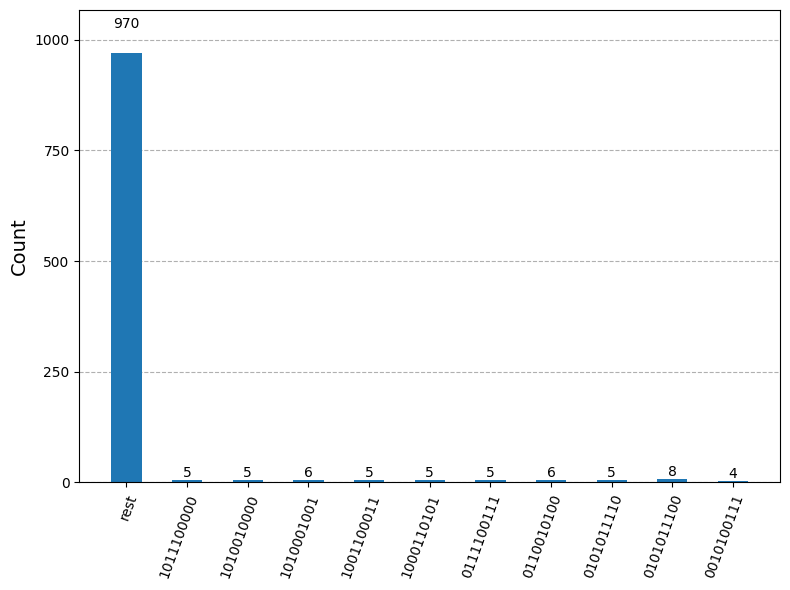

In [20]:
naive_job = sampler.run([optimized_naive_ansatz])
naive_res = naive_job.result()

counts = naive_res[0].data.meas.get_counts()
most_likely_bitstring = max(counts, key=counts.get)
naive_sol = most_likely_bitstring

print(f"\nNaive aproximation: {naive_sol}")
plot_histogram(counts, number_to_keep=10, sort='desc', figsize=(8,6))